# Introdução

Usamos o dataset sugerido da textura dos pneus rachados ou normais. Classificação binária, fácil de diferenciar.

# Estratégia

Carregamos o dataset e fizemos diversas transformações com `ImageDataGenerator` imagem por imagem, para que o modelo generalizasse bem imagens transformadas ou parecidas.

# Artigos úteis

- [1] https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
- [2] https://rohan09.medium.com/building-and-using-a-convolutional-neural-network-cnn-for-image-classification-with-keras-and-7abf571f0abb

In [1]:
import os  # Diretórios
import numpy as np # Não usei
import matplotlib.pyplot as plt # Plotação
import tensorflow as tf # Importação pra evitar erros com o keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Carrega imagens dinamicamente da pasta e gera imagens transformadas diversas para o modelo generalizar melhor
from tensorflow.keras.applications import VGG16 # CNN pré-treinada da imagenet. Transfiro o aprendizado e adiciono camadas novas pro problema do pneu.
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D # Camadas.
from tensorflow.keras.models import Model # Construção do modelo..
from tensorflow.keras.optimizers import Adam # Otimizador que altera a taxa de aprendizado (pesos) no treino
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix # Métricas pedidas no trabalho

## Diretórios

- train_dir é o diretório das imagens usadas pro treino
- val_dir é o diretório das imagens inéditas (8 por classe) pra avaliar o desempenho no treino
- test_dir é o diretório de imagens inéditas pra testar a precisão do modelo pós-treino.

In [2]:
base_dir = 'tire_textures'
train_dir = os.path.join(base_dir, 'training_data')
val_dir = os.path.join(base_dir, 'validation_data')
test_dir = os.path.join(base_dir, 'testing_data')

## Parâmetros do modelo

O VGG16 recebe imagens de 224x224 pixels, então adotei esse valor.
O tamanho do batch é o num. de imagens processadas em cada iteração durante o treino. Escolhi 32 por ser um valor comum no stackoverflow que o pessoal adota.

In [3]:
img_width, img_height = 224, 224
batch_size = 32

## Geradores de imagens

Guardo configs de transformação futura na classe ImageDataGenerator para usar no flow_from_directory. Nela faço normalização, transformação, escala, rotação da imagem, e até flip horizontal assim que carrego as fotos no dataset. Ou seka. diversas imagens a partir de uma são criadas e guardadas no train_generator/val_generator/test_generator.

Eu não faço alterações drásticas nas imagens do dataset validação e teste pois são cenários reais sem variação forçada.

In [4]:
# Criação dos ImageDataGenerators para treino, validação e teste
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador para treinamento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # classificação binária: cracked vs normal
)

# Gerador para validação
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Gerador para teste
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,      # Para avaliação, processo uma imagem por vez
    class_mode='binary',
    shuffle=False   # Preservo a ordem.
)

Found 687 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


## Amostragem

Ploto as imagens mostrando exemplos de pneus rachados e normais após carregamento no dataset.

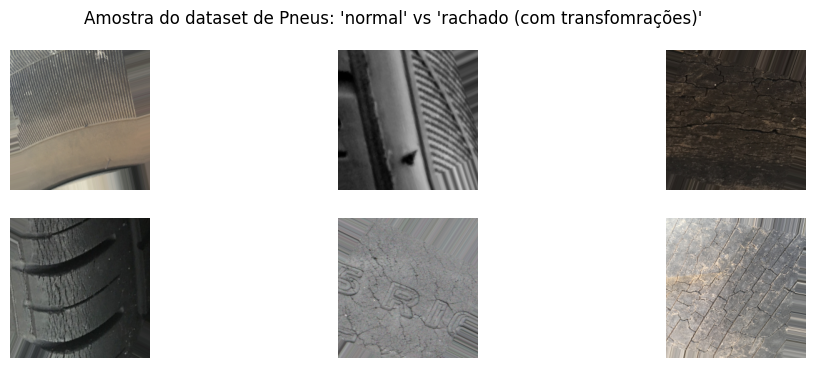

In [5]:
# Exibição de alguns exemplos do dataset
import random
sample_imgs, _ = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
plt.suptitle("Amostra do dataset de Pneus: 'normal' vs 'rachado (com transfomrações)'")
plt.show()

## VGG16 (modelo de visão computacional)

O artigo original do Simonyan e Zisserman de 2014 não diz quanto tempo levou o treino, mas provavelmente levou semanas com diversas GPU Nvidia Titan.

É capaz de classificar 1000 imagens de 1000 diferentes categorias com 92.7% de acurácia. Popular, fácil de usar e fácil de transferir aprendizado.

`include_top` está falso porque precisamos das últimas camadas para treinar o modelo de classificar pneus. Colocar falso exclui as últimas camadas originais.

O loop garante que os pesos do VGG16 não vão ser atualizados no treinamento a cada camada. Isso garante que o modelo não vai perder o aprendizado original durante o treino visando os pneus.

In [6]:
# Construção da arquitetura utilizando transferência de aprendizado com VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Congela as camadas do VGG16
for layer in base_model.layers:
    layer.trainable = False

## Criação das camadas

Pego a saída do modelo VGG16 `base_model.output` e vou adicionando camadas minhas a partir dele.


### GlobalAveragePooling2D

Aparenta ser melhor que o Flatten. Pelo que estudei, reduz muito mais parâmetros, menos risco de overfitting e mantém informações essenciais.

### Dense

Conecta os neurônios da camada anterior aos neurônios da camada seguinte. Essa camada é usada em classificação, regressão e aprendizado profundo. Aplica uma transformação linear na entrada e adiciona uma função de ativação.

| Ativação | Fórmula | Uso Comum |
|----------|--------|-----------|
| `relu` | $ \max(0, x) $ | Camadas ocultas |
| `sigmoid` | $\frac{1}{1+e^{-x}}$ | Saída para classificação binária |
| `softmax` | $\frac{e^{x_i}}{\sum e^{x_j}}$ | Saída para classificação multiclasse |
| `tanh` | $\frac{e^x - e^{-x}}{e^x + e^{-x}}$ | Alternativa ao ReLU |

### Dropout

Desativa aleatoriamente neurônios de uma camada com uma probabilidade $p$. Ajuda a reduzir o overfitting. Isso significa que esses neurônios não participam da forward pass nem da backpropagation naquele passo.

- Se tiver uma camada `Dense(128)` e aplicar `Dropout(0.5)`, metade dos neurônios vão ser desligados aleatoriamente em cada atualização dos pesos.
- Durante a inferência (teste), todos os neurônios são utilizados normalmente, mas com os pesos ajustados para compensar a falta de neurônios durante o treino.

### Camada 4

Camada final com 1 neurônio e ativação sigmoide, que gera uma saída entre 0 e 1 para classificação binária (cracked ou normal).

In [7]:
# Adiciona camadas customizadas para a classificação binária
x = base_model.output
x = GlobalAveragePooling2D()(x) # Camada 1
x = Dense(256, activation='relu')(x) # Camada 2. 256 neurônios
x = Dropout(0.5)(x) # Camada 3
predictions = Dense(1, activation='sigmoid')(x)  # Camada 4: Saída

## Construção final do modelo

Constrói o modelo final unindo a base pré-treinada (VGG16) com as camadas que eu defini.

### model.compile(...):

Configura o modelo para o treinamento:

- `optimizer=Adam(learning_rate=0.0001)`: Utiliza o otimizador Adam com uma taxa de aprendizado de 0.0001
- `loss='binary_crossentropy'`: Usado pra classificação binária
- `metrics=['accuracy']`: Monitora a acurácia durante o treinamento.

No final exibe um resumo da arquitetura do modelo, incluindo a quantidade de parâmetros treináveis e não treináveis.

In [8]:

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Treinamento do modelo

Definimos o número de épocas, que são as iterações completas sobre o conjunto de treino para 12. Achamos esse valor o mais adequado sem causar muito overfitting.

`model.fit()` inicia o treinamento, com os dados de treino, quantos batches vão ser processados por ´epoca, defino os dados de validação, quantos batches de validação vão ser processados por época, e o número de épocas.

Adicionamos um checkpoint pra pegar o melhor modelo treinado entre as épocas.

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Treinamento do modelo
epochs = 25
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stop, checkpoint],  # passe a lista de callbacks
)


c:\Users\Diassis2024\Documents\victor_projetos\inteligencia-artificial-trabalho-2\ia-venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5221 - loss: 0.7291

21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5222 - loss: 0.7285 - val_accuracy: 0.6250 - val_loss: 0.6735
Epoch 2/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5625 - loss: 0.7556

c:\Users\Diassis2024\Documents\victor_projetos\inteligencia-artificial-trabalho-2\ia-venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5625 - loss: 0.7556 - val_accuracy: 0.6250 - val_loss: 0.6717
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5750 - loss: 0.6913

21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5758 - loss: 0.6904 - val_accuracy: 0.7500 - val_loss: 0.6271
Epoch 4/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5312 - loss: 0.6853

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.5312 - loss: 0.6853 - val_accuracy: 0.7500 - val_loss: 0.6256
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6084 - loss: 0.6550

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6086 - loss: 0.6542 - val_accuracy: 0.8125 - val_loss: 0.5862
Epoch 6/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6562 - loss: 0.6176

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6562 - loss: 0.6176 - val_accuracy: 0.8125 - val_loss: 0.5849
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6137 - loss: 0.6445

21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6160 - loss: 0.6429 - val_accuracy: 0.8125 - val_loss: 0.5513
Epoch 8/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6250 - loss: 0.5881

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6250 - loss: 0.5881 - val_accuracy: 0.8125 - val_loss: 0.5502
Epoch 9/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7100 - loss: 0.5866

21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7107 - loss: 0.5863 - val_accuracy: 0.9375 - val_loss: 0.5212
Epoch 10/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6250 - loss: 0.6026

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6250 - loss: 0.6026 - val_accuracy: 0.9375 - val_loss: 0.5185
Epoch 11/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7403 - loss: 0.5530

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7403 - loss: 0.5530 - val_accuracy: 0.9375 - val_loss: 0.4870
Epoch 12/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6875 - loss: 0.5567

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.6875 - loss: 0.5567 - val_accuracy: 0.9375 - val_loss: 0.4860
Epoch 13/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7354 - loss: 0.5509

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7350 - loss: 0.5508 - val_accuracy: 0.9375 - val_loss: 0.4654
Epoch 14/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8750 - loss: 0.4773

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8750 - loss: 0.4773 - val_accuracy: 0.9375 - val_loss: 0.4645
Epoch 15/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7451 - loss: 0.5373

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7457 - loss: 0.5369 - val_accuracy: 0.9375 - val_loss: 0.4461
Epoch 16/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8438 - loss: 0.4428

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8438 - loss: 0.4428 - val_accuracy: 0.9375 - val_loss: 0.4456
Epoch 17/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7859 - loss: 0.5179

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7861 - loss: 0.5174 - val_accuracy: 0.9375 - val_loss: 0.4217
Epoch 18/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7812 - loss: 0.5588

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7812 - loss: 0.5588 - val_accuracy: 0.9375 - val_loss: 0.4208
Epoch 19/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8046 - loss: 0.4891

21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8040 - loss: 0.4895 - val_accuracy: 0.9375 - val_loss: 0.4059
Epoch 20/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7500 - loss: 0.6010

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.7500 - loss: 0.6010 - val_accuracy: 0.9375 - val_loss: 0.4050
Epoch 21/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8243 - loss: 0.4681

21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8241 - loss: 0.4682 - val_accuracy: 0.9375 - val_loss: 0.3889
Epoch 22/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7188 - loss: 0.5630

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7188 - loss: 0.5630 - val_accuracy: 0.9375 - val_loss: 0.3885
Epoch 23/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8109 - loss: 0.4547

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8108 - loss: 0.4551 - val_accuracy: 0.9375 - val_loss: 0.3738
Epoch 24/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7500 - loss: 0.4964

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7500 - loss: 0.4964 - val_accuracy: 0.9375 - val_loss: 0.3731
Epoch 25/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7855 - loss: 0.4744

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7858 - loss: 0.4743 - val_accuracy: 0.9375 - val_loss: 0.3610


## Salvamento do modelo para posterior uso

Salvo em dois formatos, um mais obsoleto e outro mais atual. Inclui a arquitetura, os pesos e as configurações de compilação.

In [10]:
# Salvando o modelo nos formatos HDF5 e no formato keras (SavedModel)
model.save('modelo_tires.h5')
model.save('modelo_tires.keras')

## Plot

Plotagem da acurácia de treino e validação, e erro de treino e validação

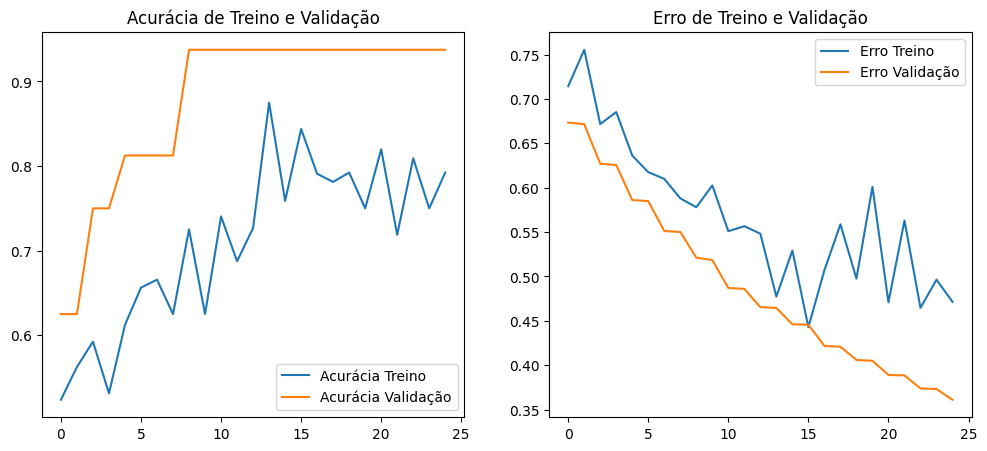

In [11]:
# Plotando as curvas de treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia Treino')
plt.plot(epochs_range, val_acc, label='Acurácia Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro Treino')
plt.plot(epochs_range, val_loss, label='Erro Validação')
plt.legend(loc='upper right')
plt.title('Erro de Treino e Validação')
plt.show()

## Avaliação 

- `test_generator.reset()` garante que o gerador de teste comece desde o início, especialmente se ele já foi usado antes.
- `model.predict(...)` Realiza predições para todas as imagens do conjunto de teste. `steps=test_generator.samples` Processa todas as amostras uma vez (batch size 1).
- `classification_report` Gera relatório detalhado com métricas como precisão, recall, F1-score e acurácia para cada classe, conforme pedido no trabalho.

In [12]:
# Avaliação do modelo no conjunto de teste
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)
# Como usa ativação sigmoide, limito a probabilidade em 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Extraindo as classes reais
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Imprime o relatório de classificação
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Relatório de Classificação:\n", report)

325/325 ━━━━━━━━━━━━━━━━━━━━ 47s 144ms/step
Relatório de Classificação:
               precision    recall  f1-score   support

     cracked       0.98      0.44      0.61       210
      normal       0.49      0.98      0.66       115

    accuracy                           0.63       325
   macro avg       0.74      0.71      0.63       325
weighted avg       0.81      0.63      0.63       325



## Análise do Gráfico

### Acurácia de Treino (azul) 

Aumenta gradualmente, chegando a valores próximos de 0.78–0.82 ao final. Ela não começa muito alta, normal nas primeiras épocas, mas depois vai melhorando conforme o modelo aprende.

### Acurácia de Validação (laranja)

Sobe para valores muito altos (cerca de 0.93) cedo e se mantém. Porém, a validação tem apenas 16 imagens (8 rachados, 8 normais). Uma variação de apenas 1 ou 2 acertos já pode mudar a acurácia de 0.50 para 0.62 ou 0.75 para 0.93, etc. Esse alto valor de validação pode ser impreciso.

### Erro de Treino (azul)

O erro de treino (linha azul) vai caindo consistentemente.

### Erro de Validação (laranja)

O erro de validação (linha laranja) também diminui, mas a diferença entre eles não é muito clara devido as poucas amostras de validação.

### Conclusão

No teste real teve só 0.63 de acurácia, mas na validação teve 0.93. Então o conjunto de validação não foi representativo. Isso provavelmente é overfitting, não generalizou bem.

## Resultado do relatório de classificação

Dado o relatório

Relatório de Classificação:
|        -         |precision |  recall  | f1-score | support |
|-----------------|----------|----------|----------|---------|
|     cracked     |   0.98   |   0.44   |   0.61   |   210   |
|      normal     |   0.49   |   0.98   |   0.66   |   115   |
|    accuracy     |    -     |    -     |   0.63   |   325   |
|   macro avg     |   0.74   |   0.71   |   0.63   |   325   |
|  weighted avg   |   0.81   |   0.63   |   0.63   |   325   |

O modelo quase nunca chama um pneu de “rachado” e erra (alta precisão), mas deixa passar a maioria dos pneus rachados (porque o recall é baixo). Basicamente ele tem medo de chamar algo de rachado. Quando chama, acerta, mas muitas vezes ele não chama (e erra).

Para pneu normal, o modelo raramente perde um pneu que é de fato normal (recall = 0.98), mas quando diz “normal”, erra quase metade das vezes (precisão = 0.49).

Resultado: 63% de acurácia global. Não é ruim, mas também não é muito confiável, por conta que envolve segurança.

## Extra: Precisão e Recall

As métricas são um pouco confusas, mas a seguir fiz uma explicação de como funcionam na prática.

#### O Que o Modelo Faz Quando Vê Uma Imagem?

Ele precisa **escolher entre duas opções**:  
✅ **"Esse pneu está rachado"**  
❌ **"Esse pneu está normal"**  

Seja um exemplo com 200 pneus para teste, 100 pneus rachados e 100 pneus normais.

Passo esses 200 pneus para o modelo. De acordo com as métricas, o que aconteceu é:

| **Imagem Real**  | **Modelo Previu**  | **Certo/Errado?** |
|-----------------|-----------------|---------------|
| Rachado ✅ | Rachado ✅ | ✅ Acertou! |
| Rachado ✅ | Rachado ✅ | ✅ Acertou! |
| Rachado ✅ | Rachado ✅ | ✅ Acertou! |
| Rachado ✅ | Rachado ✅ | ✅ Acertou! |
| Rachado ✅ | Normal ❌ | ❌ Errou! (perdeu uma rachadura) |
| Rachado ✅ | Normal ❌ | ❌ Errou! |
| Rachado ✅ | Normal ❌ | ❌ Errou! |
| Rachado ✅ | Normal ❌ | ❌ Errou! |
| Rachado ✅ | Normal ❌ | ❌ Errou! |
| Rachado ✅ | Normal ❌ | ❌ Errou! |
| ... | ... | ... |
| **TOTAL de rachados (100)** | **O modelo previu 44 rachados e errou 56!** | |

Agora os **100 pneus normais**:

| **Imagem Real**  | **Modelo Previu**  | **Certo/Errado?** |
|-----------------|-----------------|---------------|
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Rachado ❌ | ❌ Errou! (pneu normal foi classificado errado) |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| Normal ✅ | Normal ✅ | ✅ Acertou! |
| ... | ... | ... |
| **TOTAL de normais (100)** | **O modelo previu 2 como rachados e acertou 98 normais!** | |

Agora com esses dados se calcula a precisão e recall.

#### PRECISÃO (PRECISION)
Das **previsões de "rachado"**, quantas estavam certas?

- O modelo disse **"rachado"** para **46 pneus** (44 eram rachados de verdade + 2 eram normais).  
- Desses 46, **44 estavam corretos**.  

🔹 **Precisão = 44 acertos / 46 previsões de "rachado" = 0.98 (98%)**  
**Ou seja:** Quando o modelo diz "rachado", ele quase nunca erra.  

✅ **Se o modelo disse "rachado", pode confiar que está certo (98% de chance).**  

#### RECALL
Dos **100 pneus rachados de verdade**, quantos o modelo detectou?

- O modelo deveria ter detectado **100 pneus rachados**.  
- Mas ele só conseguiu detectar **44**.  
- Ele perdeu **56 rachaduras**.

🔹 **Recall = 44 detectados / 100 reais = 0.44 (44%)**  
**Ou seja:** O modelo deixou passar muitas rachaduras sem detectar.  

❌ **Se você mostrar um pneu rachado para o modelo, ele tem 56% de chance de errar e chamar de normal.**  
